# Task 1 - Setting baseline

Data Preparation

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
import time

#Load Data
data = pd.read_csv('X_train.csv')
data_test_kangle = pd.read_csv('X_test.csv')

def data_no_collisions(data):
    return data[(data['t'] == 0) & ((data[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']] != 0).any(axis=1))]

#Data split
def train_test_split_new(data):
    
    #20% for test data,10% for the validation data and 70% for training data
    #testPercentage = 0.2
    testPercentage = 0.89
    valPercentage = 0.1
    
    #Get only the rows with t = 0 AND not collisions, each representing one trajectory
    
    initialConditions = data_no_collisions(data)
    
    trainData, testData = train_test_split(initialConditions, test_size = testPercentage, random_state=50)

    trainData, valData = train_test_split(trainData, test_size = valPercentage, random_state=50)
    
    #Now we have train, validation and test data. But with only rows of t=0, we have to retrieve the rest of the rows with t>0
    #We merge the rows from the original data that have the same "trajectory_Id" as the new data sets
    
    finalTrain = pd.merge(data, trainData[['trajectory_Id']], on='trajectory_Id', how='inner')
    finalVal   = pd.merge(data, valData[['trajectory_Id']], on='trajectory_Id', how='inner')
    finalTest  = pd.merge(data, testData[['trajectory_Id']], on='trajectory_Id', how='inner')
    

    return finalTrain, finalVal, finalTest

# Creating a new column so that we can easily get all the rows of the reamining trajetory
# We create a new column based on the "index" of each row of the original data; We divide the row by 257 and round down to get the trajectory ID.
# data.index is an index of the data set, which is +1 than the Id of each data point
data['trajectory_Id']               = np.floor((data.index  ) / 257 ).astype(int)


# Splitting the data between each data set
trainData, valData, testData = train_test_split_new(data)

# Getting rid of Duplicates
trainNoDuplicates   = trainData.drop_duplicates(subset=["Id"])
valNoDuplicates     = valData.drop_duplicates(subset=["Id"])
testNoDuplicates    = testData.drop_duplicates(subset=["Id"])


# First we need to split the data intro features and predictions 
# X_train and X_test are the features (data point of the start of the trajectories)
# y_train and y_test are the targets (positions of the trajectory) 
X_test          = testNoDuplicates[(testNoDuplicates['t'] == 0) & ((testNoDuplicates[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']] != 0).any(axis=1))]
X_train         = trainNoDuplicates[(trainNoDuplicates['t'] == 0) & ((trainNoDuplicates[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']] != 0).any(axis=1))]
X_val           = valNoDuplicates[(valNoDuplicates['t'] == 0) & ((valNoDuplicates[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']] != 0).any(axis=1))]


# The X_test.csv document only has initial positions
X_test_Kangle   = data_test_kangle[(data_test_kangle['t'] >= 0)]


y_test          = testNoDuplicates[(testNoDuplicates['t'] >= 0 )]
y_train         = trainNoDuplicates[(trainNoDuplicates['t'] >= 0)]
y_val           = valNoDuplicates[(valNoDuplicates['t'] >= 0)]

# Mechanic used to get a correlation between features and predicted values
# We are adding new rows to the X_test in order to have a correspondation on the predicted values
# In this way, we will have a starting point for each of the predicted values on a given time in the same trajectory
# So, we will have 1 inicial point for each of the predicted values, in this way we will have 258 data points on the    
#       feature data and 258 points on the targets data for each trajectory 
X_test_merge            = pd.merge(y_test[['trajectory_Id']], X_test, on='trajectory_Id', how='left')
X_train_merge           = pd.merge(y_train[['trajectory_Id']], X_train, on='trajectory_Id', how='left') 
X_val_merge             = pd.merge(y_val[['trajectory_Id']], X_val, on='trajectory_Id', how='left')     



#Drop colums that are not necessary for the training/testing
X_test_merge            = X_test_merge.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])
X_train_merge           = X_train_merge.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])
X_val_merge             = X_val_merge.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])
X_test_Kangle           = X_test_Kangle.drop(columns=['Id'])

y_test                  = y_test.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])
y_train                 = y_train.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])
y_val                   = y_val.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','Id','trajectory_Id'])

Linear Regression

4.054379357805202


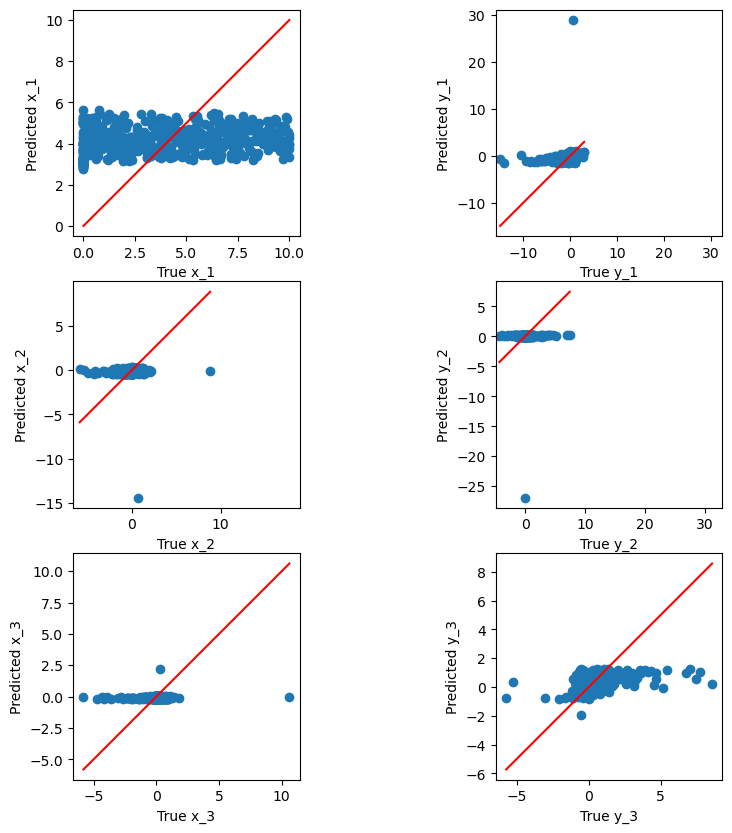

In [3]:
def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

pipeline.fit(X_train_merge, y_train)


y_pred_val = pipeline.predict(X_val_merge)
test_rmse = root_mean_squared_error(y_val, y_pred_val)
print(test_rmse)

# Testing locally/Kangle
y_pred = pipeline.predict(X_test_merge)
#y_pred = pipeline.predict(X_test_Kangle)

plot_y_yhat(y_test.values, y_pred)

#Add id column to the predicted positions
id_number = np.arange(len(y_pred))
y_pred_Df = pd.DataFrame(y_pred, columns=['t','x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'])
y_pred_Df.insert(0, 'Id', id_number)
y_pred_Df = y_pred_Df.drop(columns=['t'])


y_pred_Df.to_csv('baseline-model.csv', index=False)

# Task 2 - Nonlinear Model

Poly regression validation

In [1]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,7), max_features=None):
    winner_rmse = float('inf')
    winner_model = None
    winner_degree = None

    for degree in degrees:
        pipeline = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree),
        RidgeCV()
        )

        pipeline.fit(X_train, y_train)

        y_pred_val = pipeline.predict(X_val)
        #y_pred = pipeline.predict(X_test_Kangle)
        test_rmse = root_mean_squared_error(y_val, y_pred_val)

        if test_rmse < winner_rmse:
            winner_rmse = test_rmse
            winner_model = pipeline
            winner_degree = degree

        n_features = pipeline.named_steps['polynomialfeatures'].n_output_features_
        print(f"Degree: {degree}, RMSE: {test_rmse:.4f}, Number of Features: {n_features}")
        del pipeline
    
    return winner_model, winner_rmse, winner_degree

results = []
runs = 10

for _ in range(runs):
    winner_model, winner_rmse, winner_degree = validate_poly_regression(X_train_merge, y_train, X_val_merge, y_val)
    results.append(winner_degree)

# Plotting
plt.figure(figsize=(10, 6))
results_df = pd.DataFrame(results, columns=['Best Degree'])
results_df['Best Degree'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Defines the best degree & model
final_degree = winner_degree
final_model = make_pipeline(
    PolynomialFeatures(degree=final_degree, include_bias=False),
    RidgeCV()
)

final_model.fit(X_train_merge, y_train)

y_pred_test = final_model.predict(X_test_merge)

submission_df = pd.DataFrame(y_pred_test, columns=['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'])
submission_df.insert(0, 'Id', np.arange(len(submission_df)))
submission_df.to_csv('polynomial_submission.csv', index=False)   

NameError: name 'X_train_merge' is not defined

Poly regression evaluation

In [ ]:
def plot_y_yhat_poly(y_val, y_pred, plot_title="plot"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    MAX = 500
    
    if y_val.shape != y_pred.shape:
        raise ValueError("The shapes of y_val and y_pred must match.")

    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val), MAX, replace=False)
    else:
        idx = np.arange(len(y_val))

    plt.figure(figsize=(10, 10))
    for i in range(6):
        x0 = np.min(y_val[idx, i])
        x1 = np.max(y_val[idx, i])
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_val[idx, i], y_pred[idx, i], alpha=0.7)
        plt.xlabel('True ' + labels[i])
        plt.ylabel('Predicted ' + labels[i])
        coeffs = np.polyfit(y_val[idx, i], y_pred[idx, i], deg=final_degree)
        poly_line = np.poly1d(coeffs)
        x_vals = np.linspace(x0, x1, 100)
        plt.plot(x_vals, poly_line(x_vals), color='blue', linestyle='--', label='Fitted Line')   
        plt.axis('square')
        plt.title(f'Actual vs Predicted for {labels[i]}')
        plt.legend()
        
    plt.tight_layout()
    plt.savefig(plot_title + '.pdf')
    plt.show()

# Plotting prediction & results
y_pred_val = final_model.predict(X_val_merge)
plot_y_yhat_poly(y_val.values, y_pred_val, plot_title="Polynomial Regression Predictions")

# Task 3 - Feature Engineering

Redundancy, i.e., highest correlated data

In [ ]:
results = []
runs = 3
winner_model = None
winner_degree = 0
winner_rmse = float('inf')

main_features = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
features = main_features + ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']
df_features = ['t'] + main_features

def redundancy(test_data):
    correlation_threshold = 0.7
    correlation_matrix = test_data.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    reduced_data = test_data.drop(columns=to_drop)

    print(f'Redundant features: {to_drop}')
    print(f'Final data:\n{reduced_data.head()}')
    return reduced_data, to_drop

redundancy_data, to_drop = redundancy(data)

data_test_kangle_reduced, to_drop_kangle = redundancy(data_test_kangle)

redundancy_data, to_drop = redundancy(X_train_merge)

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

pipeline.fit(X_train_merge.drop(columns=to_drop), y_train.drop(columns=to_drop))

# Testing locally/Kangle
y_pred = pipeline.predict(X_val_merge.drop(columns=to_drop))

# Hardcode the coefficient values
x_3_pred = np.array([value[1] * -0.79 for value in y_pred])
y_3_pred = np.array([value[2] * -0.78 for value in y_pred])

y_pred = np.c_[y_pred, x_3_pred]
y_pred = np.c_[y_pred, y_3_pred]

plot_y_yhat(y_val.values, y_pred)

# Add id colum to the predicted positions
id_number = np.arange(len(y_pred))
y_pred_Df = pd.DataFrame(y_pred, columns= df_features)
y_pred_Df.insert(0, 'Id', id_number)
y_pred_Df = y_pred_Df.drop(columns=['t'])
y_pred_Df.to_csv('baseline-model.csv', index=False)

redundancy_data, to_drop = redundancy(X_train_merge)

for _ in range(runs):
    test_model, test_rmse, test_degree = validate_poly_regression(
        X_train_merge[:int(len(X_train_merge) * 0.01)].drop(columns=to_drop), y_train[:int(len(y_train) * 0.01)].drop(columns=to_drop),
        X_val_merge.drop(columns=to_drop), y_val.drop(columns=to_drop), degrees=range(1, 5))
    results.append(test_degree)

    if test_rmse < winner_rmse:
        winner_rmse = test_rmse
        winner_degree = test_degree
        winner_model = test_model

print(winner_rmse)

y_pred = winner_model.predict(X_test_Kangle.drop(columns=to_drop, errors='ignore'))

submission_df = pd.DataFrame(y_pred, columns=df_features)
submission_df.insert(0, 'Id', np.arange(len(submission_df)))
submission_df = submission_df.drop(columns=['t'])
submission_df.to_csv('polynomial_submission.csv', index=False)

Acceleration

In [2]:
# Add new features on the dataset
# Accelaration
data['Accelaration_x1'] =   data['v_x_1'].diff() / data['t'].diff()
data['Accelaration_y1'] =   data['v_y_1'].diff() / data['t'].diff()

data['Accelaration_x2'] =   data['v_x_2'].diff() / data['t'].diff()
data['Accelaration_y2'] =   data['v_y_2'].diff() / data['t'].diff()

data['Accelaration_x3'] =   data['v_x_3'].diff() / data['t'].diff()
data['Accelaration_y3'] =   data['v_y_3'].diff() / data['t'].diff()

data.fillna(0, inplace=True)

Relative velocities

In [3]:
# Adding relative velocities to the dataset
data['Relative_velocity_x_12'] =   data['v_x_1'].diff() - data['v_x_2'].diff()
data['Relative_velocity_y_12'] =   data['v_y_1'].diff() - data['v_y_2'].diff()

data['Relative_velocity_x_13'] =   data['v_x_1'].diff() - data['v_x_3'].diff()
data['Relative_velocity_y_13'] =   data['v_y_1'].diff() - data['v_y_3'].diff()

data['Relative_velocity_x_23'] =   data['v_x_2'].diff() - data['v_x_3'].diff()
data['ARelative_velocity_y_23'] =   data['v_y_2'].diff() - data['v_y_3'].diff()

data.fillna(0, inplace=True)

# Task 4 - kNN regressor

2.2103393381543284
2.103456110349108
1.9560535626562658
1.9560535626562658
10
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_jobs=-1, n_neighbors=10))])


c:\Users\Ladybug\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


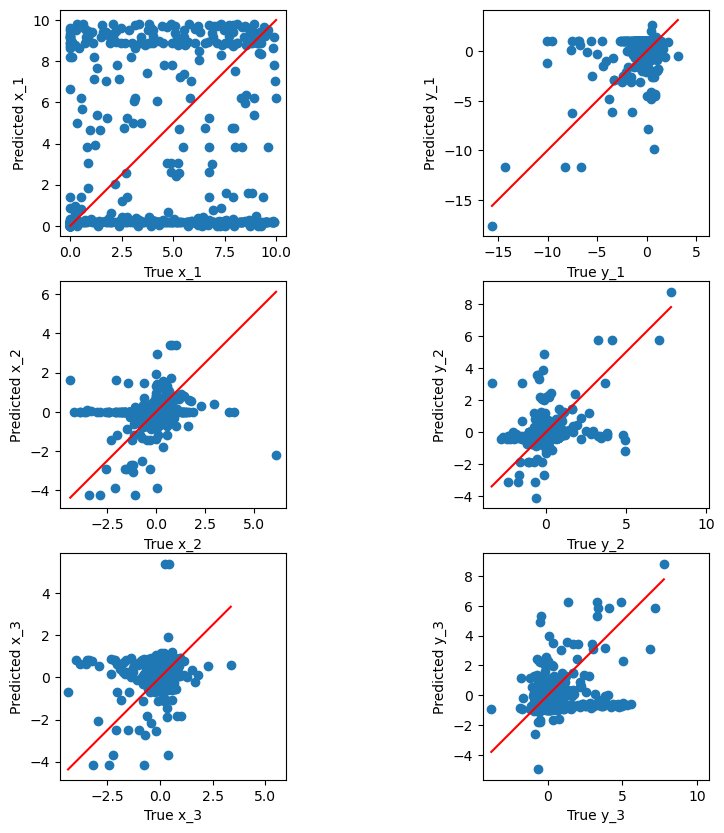

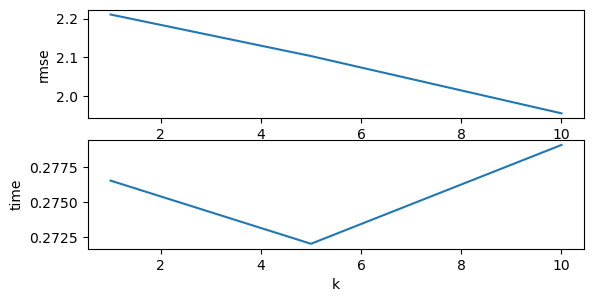

In [8]:
# k = [1, 10, 50, 100, 250, 500, 600, 686, 700, 750, 1000, 1250, 1500, 2000, 3000]
k = [1, 5, 10]
main_features = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
features = main_features + ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']
df_features = ['t'] + main_features

def validate_knn_regression(X_train, y_train, X_val, y_val, k = range(1, 15)):
    best_rmse = float('inf')
    best_k = 0
    best_model = None

    results_rmse = {}
    results_time = {}

    for test_k in k:
        ts_start = time.time()

        pipeline = make_pipeline(
            StandardScaler(),
            KNeighborsRegressor(test_k, n_jobs=-1),
        )

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_val)
        test_rmse = root_mean_squared_error(y_val, y_pred)

        print(test_rmse)

        results_rmse[test_k] = test_rmse
        results_time[test_k] = time.time() - ts_start

        if test_rmse < best_rmse:
           best_rmse = test_rmse
           best_k = test_k
           best_model = pipeline


    return best_rmse, best_k, best_model, results_rmse, results_time

result_rmse, result_k, result_model, results_rmse, result_time = (
    validate_knn_regression(X_train_merge.values, y_train.values, X_val_merge.values, y_val, k))

print(result_rmse)
print(result_k)
print(result_model)

y_pred = result_model.predict(X_test_merge)

id_number = np.arange(len(y_pred))
knn_df = pd.DataFrame(y_pred, columns=df_features)
knn_df.insert(0, 'Id', id_number)
knn_df = knn_df.drop(columns=['t'])
knn_df.to_csv('knn_submission.csv', index=False)

plot_y_yhat(y_test.values, y_pred)

plt.figure()
plt.subplot(311)
plt.plot(results_rmse.keys(), results_rmse.values())
plt.xlabel('k')
plt.ylabel('rmse')

plt.subplot(312)
plt.plot(result_time.keys(), result_time.values())
plt.xlabel('k')
plt.ylabel('time')

plt.show()